In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [2]:
data = pd.read_csv('train.csv', parse_dates=['date'])

In [3]:
data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


# 1. Data Preprocessing

In [4]:
data.groupby('store_nbr')['sales'].sum().sort_values(ascending=False).head(3)

store_nbr
44    6.208755e+07
45    5.449801e+07
47    5.094831e+07
Name: sales, dtype: float64

We will use the store that has the highest total sales

In [5]:
data_ts = data[data['store_nbr'] == 44]
data_ts  = data_ts.groupby('date')['sales'].sum().reset_index()
print(data_ts.info())
data_ts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1684 non-null   datetime64[ns]
 1   sales   1684 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.4 KB
None


,date,sales
0,2013-01-01,0.000
1,2013-01-02,30095.181
2,2013-01-03,20447.057
3,2013-01-04,22795.799
4,2013-01-05,31382.508


In [6]:
# find the total dates and total sales dates
dates = pd.date_range(start=min(data_ts['date']), end=max(data_ts['date']))
print('Total Days sales:', data_ts.shape[0])
print('Total Days Corret:', len(dates))

# Performing left join
dates = pd.DataFrame(dates, columns=['date'])
data_ts = dates.merge(data_ts,on='date',how='left')



Total Days sales: 1684
Total Days Corret: 1688


In [7]:
print(data_ts.isnull().sum())
data_ts[data_ts['sales'].isnull()]

date     0
sales    4
dtype: int64


,date,sales
358,2013-12-25,NaN
723,2014-12-25,NaN
1088,2015-12-25,NaN
1454,2016-12-25,NaN


We dont have transactions on December 25. This may be related to the Christmas, for these dates we will just filling the null values with 0

In [8]:
data_ts['sales'] = data_ts['sales'].fillna(0)
print(data_ts.isnull().sum())

date     0
sales    0
dtype: int64


In [9]:
# Set date to index for time series analysis
ts = data_ts.set_index('date')
ts.head()

,sales
date,
2013-01-01,0.000
2013-01-02,30095.181
2013-01-03,20447.057
2013-01-04,22795.799
2013-01-05,31382.508


# 2. Time Series Analysis

In [10]:
print('Minimum date: ', ts.index.min())
print('Maximum date: ',ts.index.max())

Minimum date:  2013-01-01 00:00:00
Maximum date:  2017-08-15 00:00:00


## 2.1 Sales performance from January 2013 to August 2017

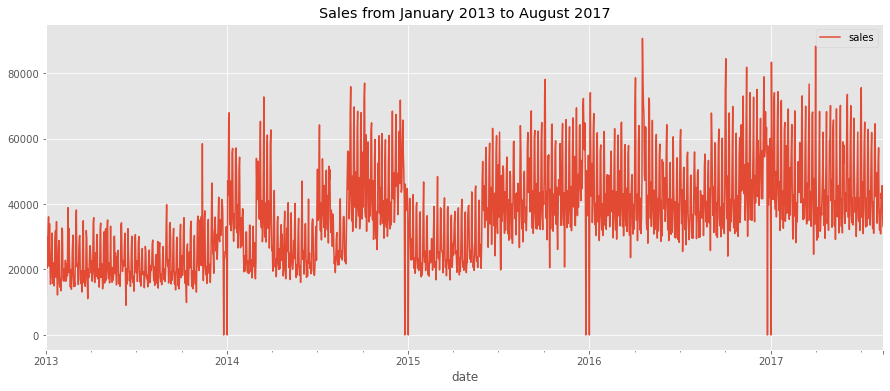

In [11]:
# Sales performance from 2013 to 2017
ts.plot(figsize=(15,6))
plt.title('Sales from January 2013 to August 2017')
plt.show()

- We can't really see the pattern. It looks like there is decreasing at the beginning of the year

## 2.2 Annual sales pattern

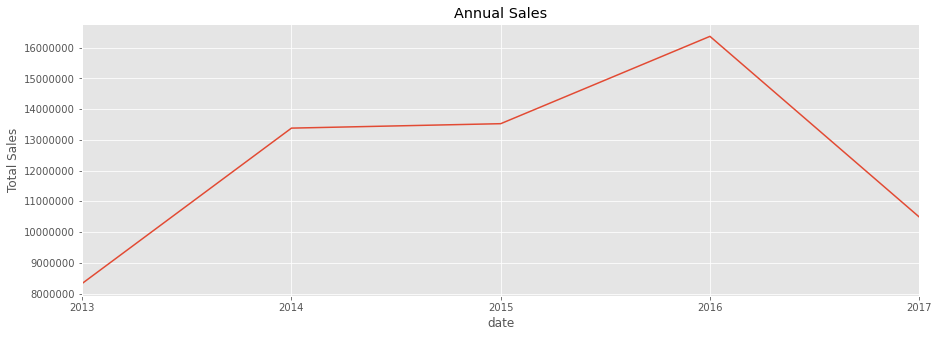

In [12]:
# Examine annual trend
plt.figure(figsize=(15,5))
ts['sales'].resample('AS').sum().plot()
plt.title('Annual Sales')
plt.ylabel('Total Sales')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

- Annual sales increasing from 2013 to 2014
- There is no significant increase from 2014 to 2015
- 2016 has the highest annual sales 
- Sales decreasing in 2017 due to our data only have the data until August 2017

## 2.2 Monthly distribution sales over the year 

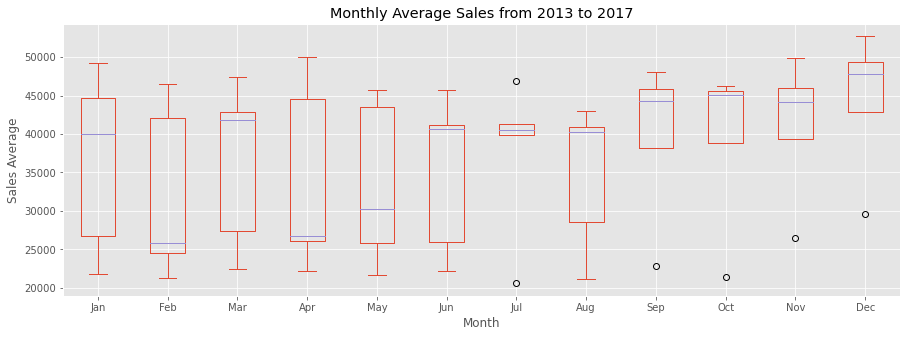

In [13]:
# Examine seasonal trend in the data
ts['Month'] = ts.index.strftime('%b')
ts['Year'] = ts.index.year

ts_pivot = ts.pivot_table(index='Year', columns='Month', values='sales')

ts = ts.drop(['Month', 'Year'], axis=1)

# put the months in order
month_names = pd.date_range(start='2013-01-01', periods=12, freq='MS').strftime('%b')
ts_pivot = ts_pivot.reindex(columns=month_names)


ts_pivot.plot(kind='box', figsize=(15,5))
plt.xlabel('Month')
plt.ylabel('Sales Average')
plt.title('Monthly Average Sales from 2013 to 2017')
plt.show()

- We can see that November and  December have the highest sales on average from 2013 to 2017
- July has the lowest distribution sales on average. And we can see that there is a 1 outlier in July with only about 20000 average sales

## 2.3 Sales distribution for January 2013 

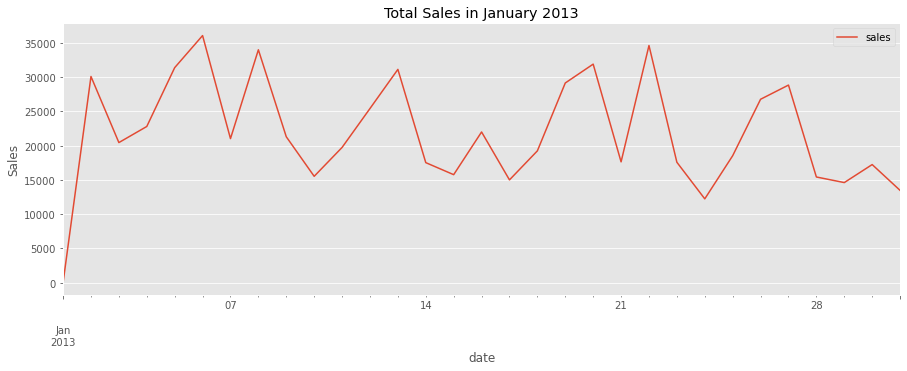

In [14]:
ts[['sales']].head(31).plot(figsize=(15,5))
plt.title('Total Sales in January 2013')
plt.ylabel('Sales')
plt.show()

- We can see that in January 2013. Sales increasing every weekend this may indicates that we have a pattern for weekly periodicity sales

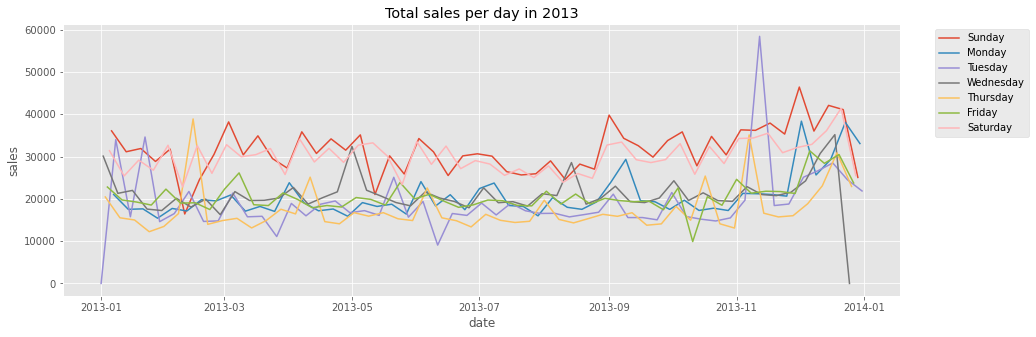

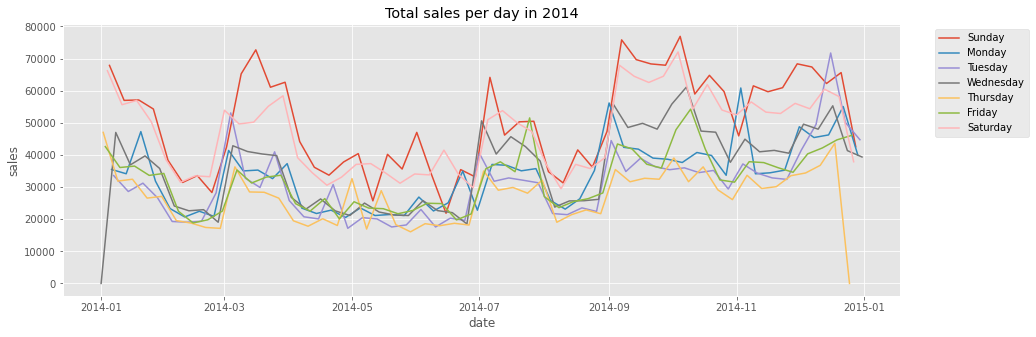

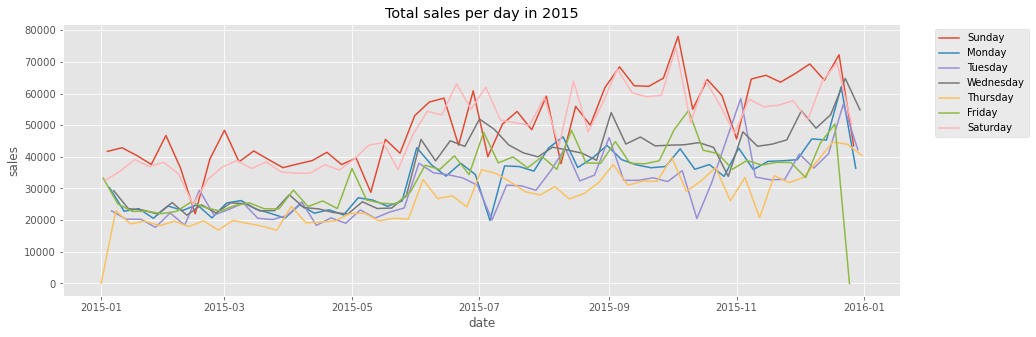

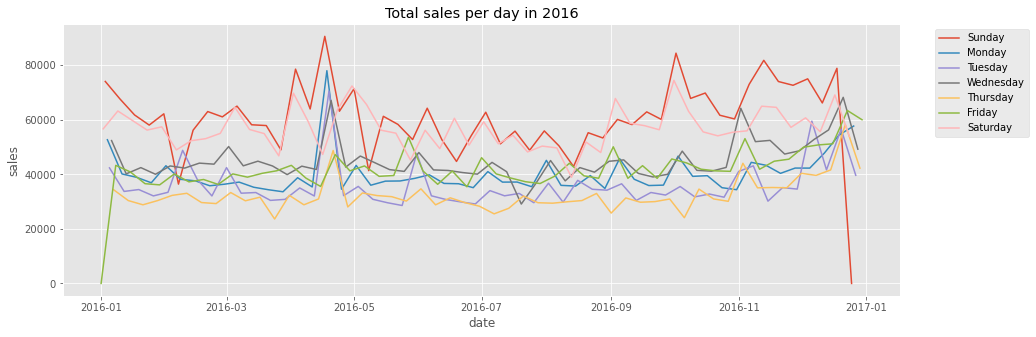

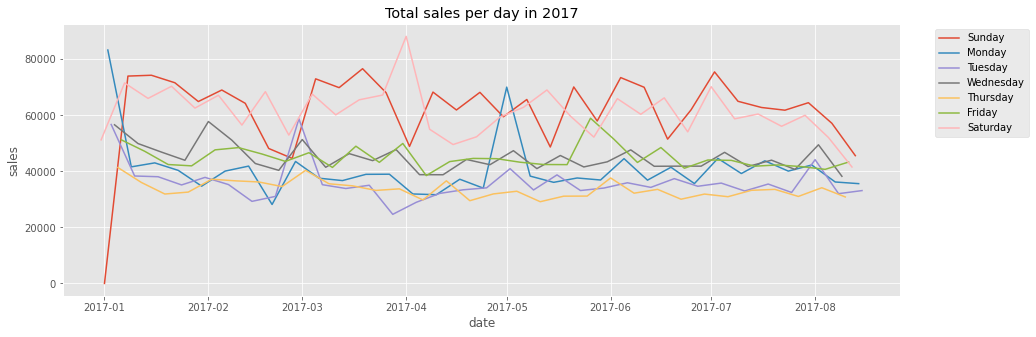

In [15]:
ts['weekday'] = ts.index.strftime('%A')
plt.figure(figsize=(15,5))

# 2013
sns.lineplot(x='date', y='sales', hue='weekday', hue_order = ts.iloc[5:].weekday.unique(), 
             data=ts.reset_index().iloc[0*365:1*365,:])
plt.title('Total sales per day in 2013')
plt.legend(bbox_to_anchor=(1.16, 1))

# 2014
plt.figure(figsize=(15,5))
sns.lineplot(x='date', y='sales', hue='weekday', hue_order = ts.iloc[5:].weekday.unique(), 
             data=ts.reset_index().iloc[1*365:2*365,:])
plt.title('Total sales per day in 2014')
plt.legend(bbox_to_anchor=(1.16, 1))

# 2015
plt.figure(figsize=(15,5))
sns.lineplot(x='date', y='sales', hue='weekday', hue_order = ts.iloc[5:].weekday.unique(), 
             data=ts.reset_index().iloc[2*365:3*365,:])
plt.title('Total sales per day in 2015')
plt.legend(bbox_to_anchor=(1.16, 1))

# 2016
plt.figure(figsize=(15,5))
sns.lineplot(x='date', y='sales', hue='weekday', hue_order = ts.iloc[5:].weekday.unique(), 
             data=ts.reset_index().iloc[3*365:4*365,:])
plt.title('Total sales per day in 2016')
plt.legend(bbox_to_anchor=(1.16, 1))

# 2017
plt.figure(figsize=(15,5))
sns.lineplot(x='date', y='sales', hue='weekday', hue_order = ts.iloc[5:].weekday.unique(), 
             data=ts.reset_index().iloc[4*365:5*365,:])
plt.title('Total sales per day in 2017')
plt.legend(bbox_to_anchor=(1.16, 1))

plt.show()

# Drop weekday column
ts.drop('weekday', axis=1, inplace=True)

- Sunday and Saturday are the highest total sales
- Thursday is the lowest day of total sales

## 2.3 Weekly and Monthly sales

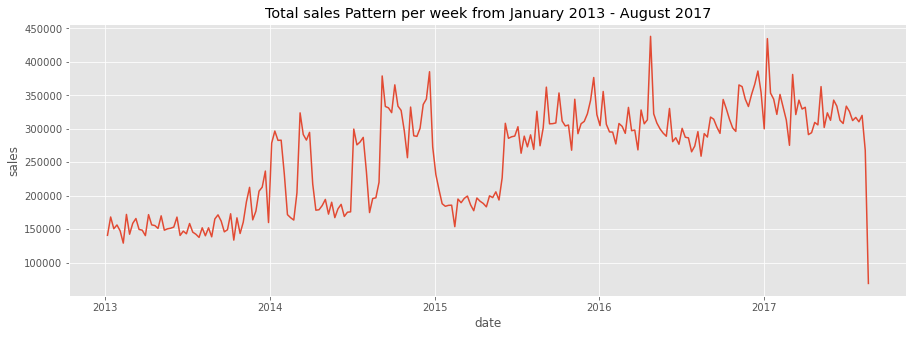

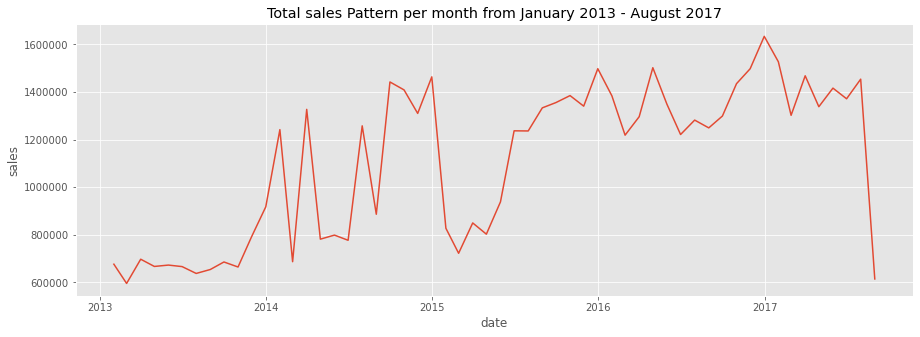

In [16]:
#weekly sales
weekly = ts['sales'].resample('w').sum()
plt.figure(figsize=(15,5))
sns.lineplot(data=weekly)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Total sales Pattern per week from January 2013 - August 2017')

#monthly sales
monthly = ts['sales'].resample('M').sum()
plt.figure(figsize=(15,5))
sns.lineplot(data=monthly)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Total sales Pattern per month from January 2013 - August 2017')

plt.show()

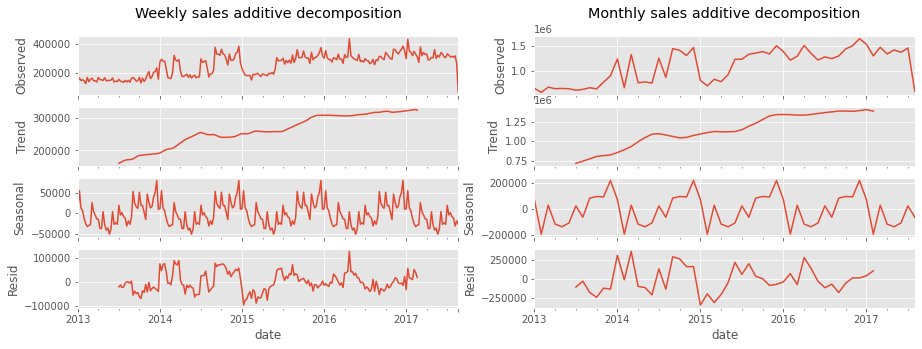

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig, ax = plt.subplots(4,2,figsize=(15,5))

#weekly sales
decomp1 = seasonal_decompose(weekly)
decomp1.observed.plot(ax=ax[0,0],ylabel='Observed',legend=None)
decomp1.trend.plot(ax=ax[1,0],ylabel='Trend',legend=None,sharex=ax[0,0])
decomp1.seasonal.plot(ax=ax[2,0],ylabel='Seasonal',legend=None,sharex=ax[0,0])
decomp1.resid.plot(ax=ax[3,0],ylabel='Resid',legend=None,sharex=ax[0,0])
ax[3,0].set_title('Weekly sales additive decomposition',x=0.5,y=4.8)


#monthly sales
decomp2 = seasonal_decompose(monthly)
decomp2.observed.plot(ax=ax[0,1],ylabel='Observed',legend=None)
decomp2.trend.plot(ax=ax[1,1],ylabel='Trend',legend=None,sharex=ax[0,0])
decomp2.seasonal.plot(ax=ax[2,1],ylabel='Seasonal',legend=None,sharex=ax[0,0])
decomp2.resid.plot(ax=ax[3,1],ylabel='Resid',legend=None,sharex=ax[0,0])
ax[3,1].set_title('Monthly sales additive decomposition',x=0.5,y=4.8)

plt.show()

- Increasing trend for weekly and monthly sales

## 2.4 Look at stationarity

Most time-series models assume that the underlying time-series data is stationary. This assumption gives us some nice statistical properties that allows us to use various models for forecasting.

Stationarity is a statistical assumption that a time-series has:

- Constant mean
- Constant variance
- Autocovariance does not depend on time

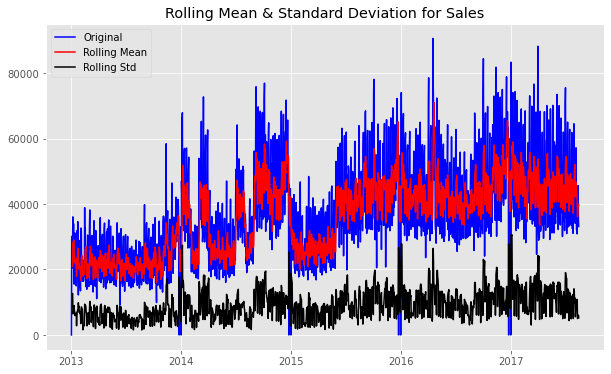

Test Statistic                   -3.014509
p-value                           0.033561
# Lags Used                      22.000000
Number of Observations Used    1665.000000
Critical Value (1%)              -3.434284
Critical Value (5%)              -2.863277
Critical Value (10%)             -2.567695
dtype: float64


In [18]:
from statsmodels.tsa.stattools import adfuller

# Determing rolling statistics
rollmean =  ts['sales'].rolling(window = 5, center = False).mean()
rollstd = ts['sales'].rolling(window = 5, center = False).std()

# Plot rolling statistics
plt.figure(figsize=(10,6))
orig = plt.plot(ts['sales'], color = 'blue', label = 'Original')
mean = plt.plot(rollmean, color = 'red',label = 'Rolling Mean')
std = plt.plot(rollstd, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Standard Deviation for %s' %('Sales'))
plt.xticks(rotation = 0)
plt.show()


# Perform Dickey-Fuller test:b
# Null Hypothesis (H_0): time series is not stationary
# Alternate Hypothesis (H_1): time series is stationary
ts_test = adfuller(ts['sales'])
ts_output = pd.Series(ts_test[0:4],
                      index = ['Test Statistic',
                                'p-value',
                                '# Lags Used',
                                'Number of Observations Used'])
for key, value in ts_test[4].items():
    ts_output['Critical Value (%s)'%key] = value
print(ts_output)


The p-value is 0.03 lower than 0.05. Hence we can say that forecasting can be done on the data without any further transformations.

## 3. Forecasting with SARIMA

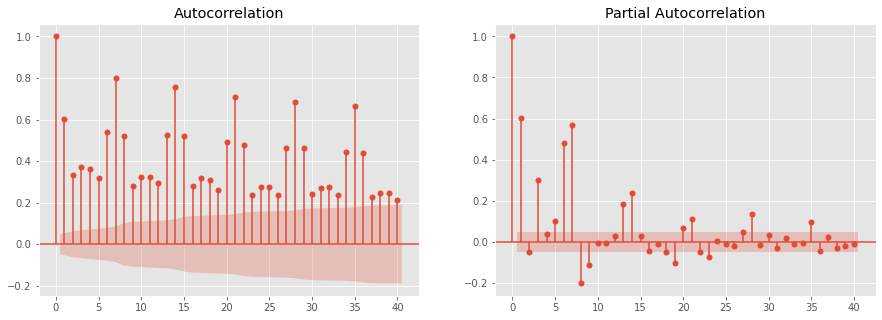

In [19]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(ts['sales'],ax=ax[0],lags=40)
plot_pacf(ts['sales'],ax=ax[1],lags=40)
plt.show()

Let's trying to identify the order from the ACF and PACF: 

First we will trying to identify from the non seasonal order. We can see that there are a few significant spikes at the beginning of a ACF plot, hence we will try use the order AR1 model.

For the seasonal order. We will trying to use the plot with a fewer number of repeated significant spikes. We can see that PACF plot has the fewer number of significant spikes. There are a significant at lag 1 and at lag 7, hence we wil try to use AR2 model.

- order = (1,0,0)
- seasonal_order = (2,1,0)

## 3.1 Split training and test set

In [20]:
# Split training and test set
ts = ts.sales
size = int(len(ts) * 0.8)
train = ts.iloc[:size]
test = ts.iloc[size:]
data = [x for x in train]

# # Make predictions with expanding window method
preds = []
for i in range(len(test)):
    model = SARIMAX(data, order=(1,0,0),seasonal_order=(2,1,0,7)).fit()
    yhat = model.forecast()[0]
    preds.append(yhat)
    data.append(test[i])
    
# Calculate out of sample error
score = mean_absolute_error(test, preds)
print('Mean absolute error(MAE) score: %f' %(score))

Mean absolute error(MAE) score: 6008.442873


## 3.2 Model summary

In [21]:
# Summary of the model
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1687
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 7)   Log Likelihood              -17454.128
Date:                           Wed, 08 Jun 2022   AIC                          34916.256
Time:                                   18:35:08   BIC                          34937.962
Sample:                                        0   HQIC                         34924.296
                                          - 1687                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3795      0.013     29.234      0.000       0.354       0.405
ar.S.L7       -0.4477      0.014    -31.862

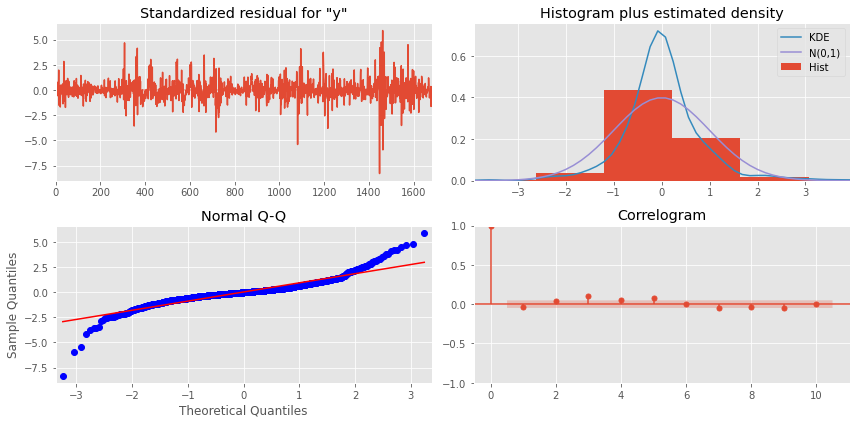

In [22]:
model.plot_diagnostics(figsize=(12,6))
plt.tight_layout()

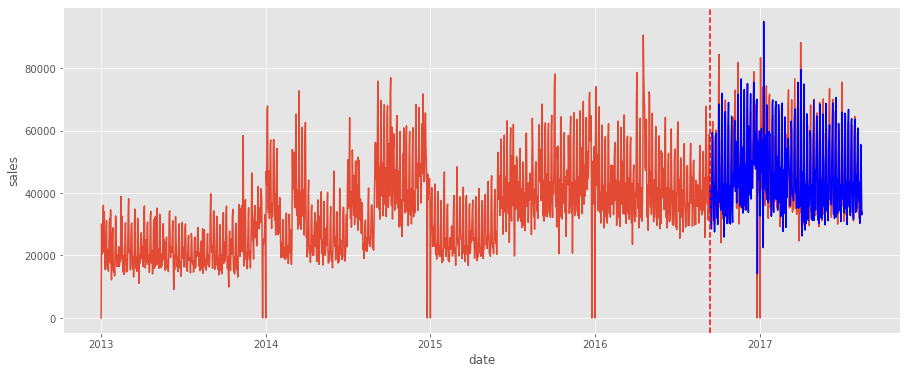

In [23]:
predicted = pd.Series(preds,index=test.index)
plt.figure(figsize=(15,6))
sns.lineplot(data=ts)
sns.lineplot(data=predicted,color='blue')
plt.axvline(x=ts.index[size],color='red',linestyle='dashed')
plt.show()

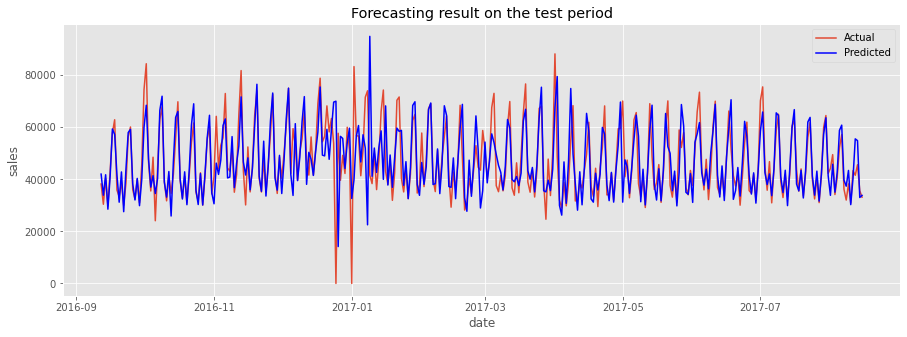

In [24]:
plt.figure(figsize=(15,5))
sns.lineplot(data=ts[size:], label='Actual')
sns.lineplot(data=predicted,color='blue',label='Predicted')
plt.title('Forecasting result')
plt.show()

## 4. Possible extensions to improve the model

1. We don't use any exogenous variable, we can try use exogenouse variables to see if improve the model
2. We can try to use different order 
3. We can try to use machine learning method rather than stastical method

## 5. Conclusion

1. Sales increasing from 2013 to 2014. But there is no significant increase from 2014 to 2015
2. 2016 is the highest total sales. But decreasing in 2017 since we have only data for 15 August 2017
3. Overall saturday and sunday are the highest values of sales compare to the other days
4. November and December are the highest of the sales average distribution
5. Increasing trend for weekly and monthly frequency